Measuring Technological Changes - Pilot 3 EURITO

This notebook contains all the workflow needed to calculate technological changes using the process developed in pilot 3 of the EURITO project. For additional details on the methodology please consult the documentation for this pilot that is available withing this repo.

This notebook extracts data from a graph database running on Neo4j. The database can be downloaded from: https://1drv.ms/u/s!ApgyMp6APyzLhYRpA49F9l876iWD2w and Neo4j can be downloaded from: http://neo4j.org

Part of this work was developed in the context of a Master thesis project at the Technical University of Denmark. Information about that master thesis project is available at: https://duarteoc.gitbook.io


Let's start by importing all of the external libraries that will be useful during the analysis. 

In [1]:
# python libraries
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from scipy.linalg import pinv
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
import operator
from IPython.display import display, HTML
from matplotlib.colors import ListedColormap



# connection to Neo4j
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

# plotly credentials
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### Extracting the data from the graph database

We start by obtaining all the terms that allow us to create Matrix A from the Graph Database. 

In [2]:
f_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
o_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Output) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
pt_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:ProcessingTech) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
bbo = list(f_terms + pt_terms + o_terms)
print 'Number of terms:', len(bbo)
axis_names = bbo
print axis_names

Number of terms: 352
[u'vegetable oil', u'recycled ethanol', u'woodwaste/bagasse', u'natural gas', u'various grasses', u'nonedible oils', u'animal fats', u'paper', u'ponderosa pine', u'grass seed', u'milo', u'osb', u'paper waste', u'corn cob', u'logging residues', u'willow', u'crop waste', u'firewood', u'jatropha', u'sugarcane bagasse', u'sugar', u'durum', u'wood', u'municipal solid waste', u'banna grass', u'waste oil', u'cassava pulp', u'barley', u'mixed oilseeds', u'wood fuel', u'starch', u'white grease', u'coniferous wood', u'corn oil', u'cellulosic sugars', u'vegetable waste', u'corn stalks', u'yellow grease', u'molasses', u'hybrid poplar', u'food waste', u'citrus residues', u'wood chips', u'spent sulphite liquor feedstock', u'palm, rapeseed oil, waste fat', u'cotton residue', u'industrial waste', u'deciduous forests', u'corn stover', u'cereals/sugar', u'waste fat', u'waste vegetable oil', u'tallow', u'sewage', u'poultry fat', u'grain', u'poplar/energy woods', u'biogas from municip

We create a function that return the matrix with the whole database.

In [3]:
def get_total_matrix(normalization):
    
    # define queries
    # non intersecting part
    q1 =         """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                RETURN fs.term, pt.term, out.term, count(a)
                """
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    # interesecting part
    q2 =        """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t
                RETURN fs.term, t.term, count(a)
                """
    # total assets of year
    q3 =        """
                MATCH (n:Asset)
                RETURN count(n)
                """
    
    # treat incoming data
    total_documents = DataFrame(connection_to_graph.data(q3)).as_matrix()[0][0]
    
    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create matrix
    total_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    # for no intersections data
    for row in data_q1:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position not inter
        for pair in itertools.combinations(indexes, 2):
            total_matrix[pair[0], pair[1]] += frequency
            total_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(q2.format(category, category))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position inter
            for pair in itertools.combinations(indexes, 2):
                total_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                total_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    norm_total_matrix = total_matrix  / total_documents
    
    # dynamic return 
    if normalization == True:
        return norm_total_matrix
    else: 
        return total_matrix

Let us visualize the normalized and non normalized versions of the matrix.

We create a function that gives borders to our graphs.

In [4]:
def borders(width, color, size=get_total_matrix(normalization=False).shape[1]):
    plt.axhline(y=0, color='k',linewidth=width)
    plt.axhline(y=size, color=color,linewidth=width)
    plt.axvline(x=0, color='k',linewidth=width)
    plt.axvline(x=size, color=color,linewidth=width)

And we plot.

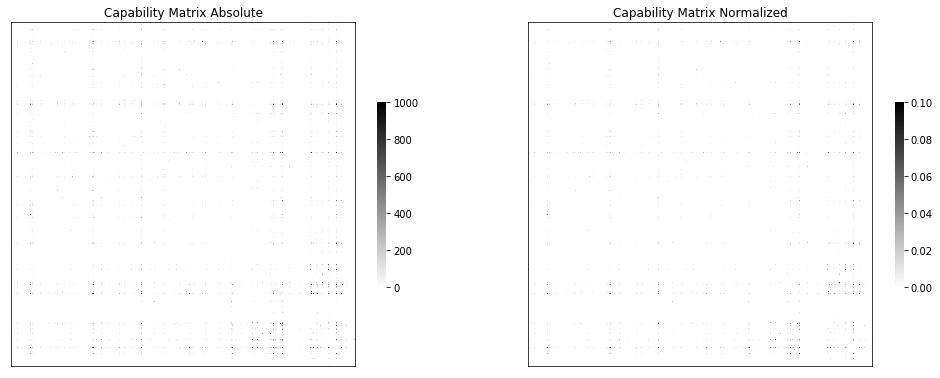

In [5]:
## call functions
colors = 'binary'

year_in_focus = 2016
# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
vmax = 1000
sns.heatmap(get_total_matrix(normalization=False) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmax=vmax)
borders(1.5, 'k')
plt.title('Capability Matrix Absolute')

# second heatmap
plt.subplot(122)
vmax = 0.1
sns.heatmap(get_total_matrix(normalization=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmax=vmax)
borders(1.5, 'k')
plt.title('Capability Matrix Normalized')
plt.show()

### Total database matrix: clustered

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:603: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



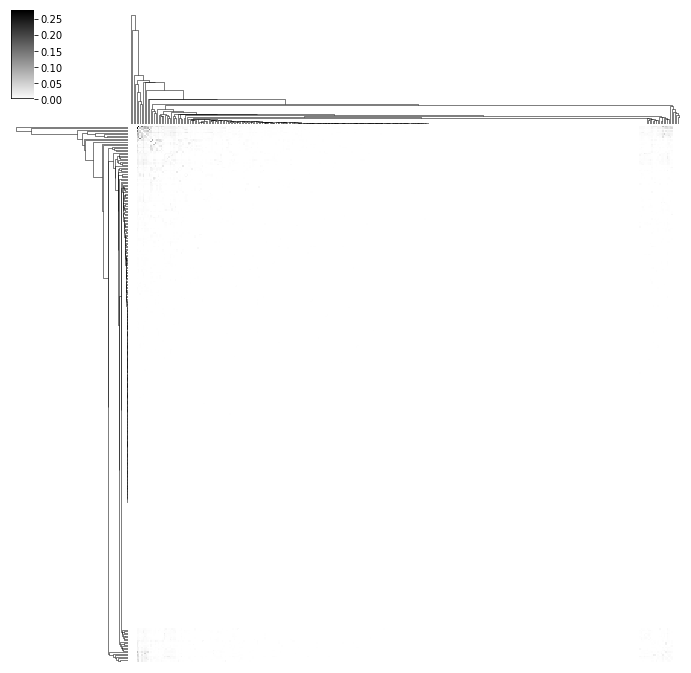

In [6]:
whole_database = get_total_matrix(normalization=True)
a = sns.clustermap(whole_database,  figsize=(12, 12), xticklabels = False, yticklabels=False, cmap='binary', square=True)
borders(1.5, 'k')
plt.show()

In [7]:
cluster_order = []
for i in a.dendrogram_row.reordered_ind:
    cluster_order.append(axis_names[i])

print 'Extract of cluster order:'
cluster_order[50:70]

Extract of cluster order:


[u'sugarcane bagasse',
 u'wood chips',
 u'pine',
 u'agricultural residues',
 u'rice straw',
 u'wheat straw',
 u'blend',
 u'succinic acid',
 u'biobutanol',
 u'oil extraction',
 u'microwave',
 u'natural gas',
 u'pellets',
 u'barley',
 u'poplar',
 u'sugar beet',
 u'grains',
 u'acid hydrolysis',
 u'consolidated bioprocessing',
 u'cbp']

## 1. Characterisation of Years <a class="anchor" id="one"></a>

### 1.1. Years in the database <a class="anchor" id="one-one"></a>

# query years
years_available_q = """     MATCH (n:Asset)
                            WITH n.year as YEAR
                            RETURN YEAR, count(YEAR)
                            ORDER BY YEAR ASC """

# create a list with the years where records exist
years_available = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()[:, 0][:-1]
years_available = [int(year) for year in years_available]

# create a pure range list
first_year = int(years_available[0])
last_year = int(years_available[-1])
real_years = range(first_year, last_year + 1, 1)

# give information 
print 'The database list starts in {}, ends in {} and contains {} years.'.format(years_available[0], years_available[-1], len(years_available))
print 'The real list starts in {}, ends in {} and contains {} years.'.format(real_years[0], real_years[-1], len(real_years))

Now that we have all of the years available, we can start building the matrices.

### 1.2. Capability Matrixes of years <a class="anchor" id="one-two"></a>

#### 1.2.1. Getting the labels <a class="anchor" id="one-two-one"></a>

The final list of terms has 352 terms. 

#### 1.2.2. Function <a class="anchor" id="one-two-two"></a>

Some auxiliary functions to help us build matrixes. 

In [9]:
def number_of_documents(term, year):
    q_term_total = """
    MATCH (a:Asset)-[:CONTAINS]->(t)
    WHERE t.term="{}" AND a.year = "{}"
    RETURN count(a)
    """.format(term, year)
    return DataFrame(connection_to_graph.data(q_term_total)).as_matrix()[0][0]

We start by creating a function that given a certain year, returns the year's  matrix. 

In [10]:
def get_year_matrix(year, normalization=True, adjacency=True, diagonal=False):
    # the values above are the default and run if not specified.
    
    q1 =         """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                WHERE a.year = "{}"
                RETURN fs.term, pt.term, out.term, count(a)
                """.format(year)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    # interesecting part
    q2 =        """    
                MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t AND a.year = "{}"
                RETURN fs.term, t.term, count(a)
                """
    # total assets of year
    q3 =        """
                MATCH (n:Asset)
                WITH n.year as YEAR
                RETURN YEAR, count(YEAR)
                ORDER BY YEAR ASC
                """
    
    # treat incoming data
    raw_data_q3 = DataFrame(connection_to_graph.data(q3)).as_matrix()
    index_of_year = list(raw_data_q3[:, 0]).index('{}'.format(year))
    total_documents = raw_data_q3[index_of_year, 1]

    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create empty matrix
    year_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    if adjacency:
        # for no intersections data
        for row in data_q1:
            # the last column is the frequency (count)
            frequency = row[0]
            indexes = [axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position not inter
            for pair in itertools.combinations(indexes, 2):
                year_matrix[pair[0], pair[1]] += frequency
                year_matrix[pair[1], pair[0]] += frequency

        # for intersecting data
        for category in process_variables:
            process_data = DataFrame(connection_to_graph.data(q2.format(category, category, year))).as_matrix()
            for row in process_data:
                frequency = row[0]
                indexes = [axis_names.index(element) for element in row[1::]]
                # add frequency value to matrix position inter
                for pair in itertools.combinations(indexes, 2):
                    year_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                    year_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
                
    if diagonal:
        for index, name in enumerate(axis_names):
            year_matrix[index, index] = number_of_documents(name, year)
                 
    
    # normalize or not 
    if normalization == True: 
        year_matrix = year_matrix / total_documents

        
    return year_matrix
        

We finally test our function with the year 2016. 

In [11]:
year = 2017
print 'The matrix from {} has shape {} a max value of {}, a min value of {} and a mean of {}.'.format(year, get_year_matrix(year).shape, np.amax(get_year_matrix(year)), np.amin(get_year_matrix(year)), np.mean(get_year_matrix(year)))

The matrix from 2017 has shape (352, 352) a max value of 0.229850746269, a min value of 0.0 and a mean of 0.000211213110583.


Let us print the  matrices of 2016 normalized and absolute versions.

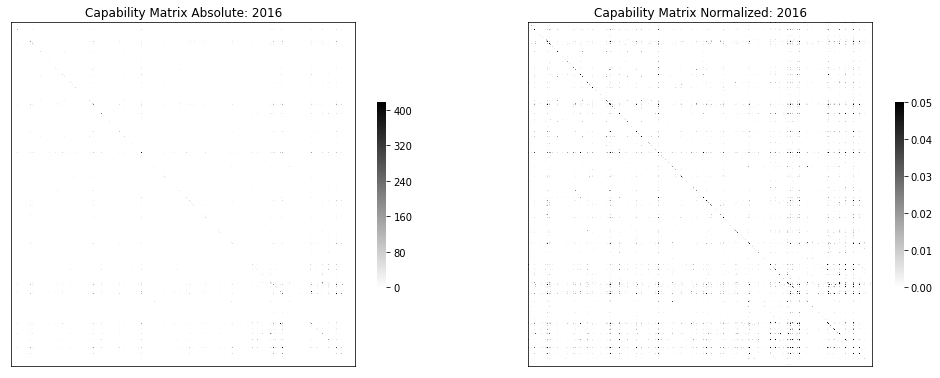

In [12]:
## call functions
colors = 'binary'
vmin = 0.0000
vmax = 0.05

year_in_focus = 2016
# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(get_year_matrix(year_in_focus, normalization=False, diagonal=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False)
borders(1.5, 'k')
plt.title('Capability Matrix Absolute: {}'.format(year_in_focus))

# second heatmap
plt.subplot(122)
sns.heatmap(get_year_matrix(year_in_focus, normalization=True, diagonal=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
borders(1.5, 'k')
plt.title('Capability Matrix Normalized: {}'.format(year_in_focus))
plt.show()

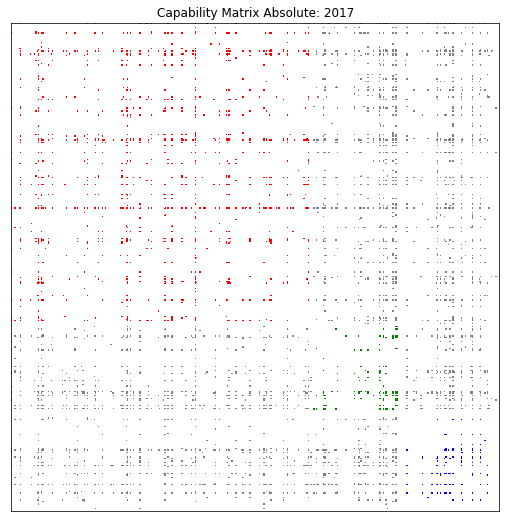

In [13]:
## call functions
color1 = 'Blues'
color3 = 'Reds'
rwhite = ListedColormap(['white', 'red'])
gwhite = ListedColormap(['white', 'green'])
blwhite = ListedColormap(['white', 'blue'])
bwhite = ListedColormap(['white', 'grey'])
year_in_focus = 2017
graph_holder = 0.001

original = get_year_matrix(year_in_focus, normalization=False)

threshold = len(f_terms)
f_mask = np.ones(original.shape)
f_mask[0:threshold, 0:threshold] = 0

threshold = len(f_terms) + len(pt_terms)
pt_mask = np.ones(original.shape)
pt_mask[len(f_terms):threshold , len(f_terms):threshold] = 0
o_mask = np.ones(original.shape)
o_mask[threshold:: , threshold::] = 0

plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(original, cmap=bwhite, center=0.001, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = f_mask, cmap=rwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = pt_mask, cmap=gwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(original, mask = o_mask, cmap=blwhite, center=graph_holder, cbar=None, square=True, xticklabels=False, yticklabels=False)
borders(1.5, 'k')

plt.title('Capability Matrix Absolute: {}'.format(year_in_focus))
plt.show()

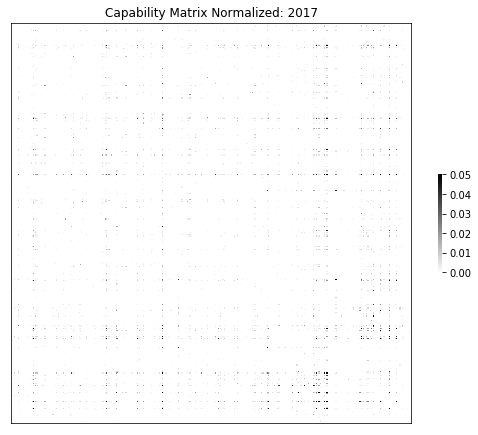

In [14]:
## call functions
colors = 'binary'
year_in_focus = 2017
# create a subplot

plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(get_year_matrix(year_in_focus, normalization=True) , cmap=colors,  cbar=True,cbar_kws={"shrink": .2}, square=True, xticklabels=False, yticklabels=False, vmin=0.00, vmax=0.05)
borders(1.5, 'k')

plt.title('Capability Matrix Normalized: {}'.format(year_in_focus))
plt.show()

### 1.3. Year profiles <a class="anchor" id="one-three"></a>

In order to analyse the correlation between years, we will need  transform each year matrix into a list. Since the matrix is symmetrical, we will only need the upper triangle. For control purposes, we have designed our own upper triangulization matrix. 

In [15]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

Let us print the  lists of two example years. 

(2, 61776)
(2, 3700)


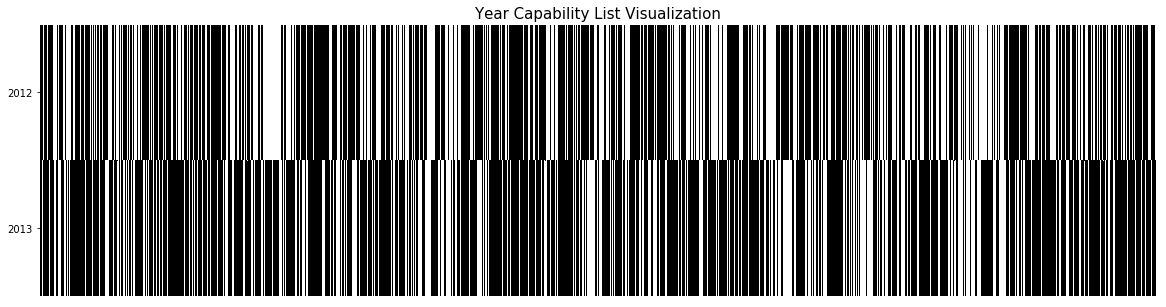

In [16]:
# apply functions to both countries
a_list = get_list_from(get_year_matrix(2012, normalization=True))
b_list = get_list_from(get_year_matrix(2013, normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((a_list, b_list))
print corelation.shape
good_cols = [i for i in range(corelation.shape[1]) if np.sum(corelation[:, i]) != 0]
        
good_corelation = corelation[:, good_cols]
print good_corelation.shape

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(good_corelation,cmap=ListedColormap(['white', 'black']), center=0.00000001, cbar=None, square=False, yticklabels=['2012', '2013'], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Year Capability List Visualization', size=15)
plt.show()

It is already apparent that these two consecutive years are highly correlated.

## 2. Year Correlation Matrix <a class="anchor" id="two"></a>

We create some functions to calculate the similarity between years. 

In [17]:
def rv_coefficient(X, Y): 
    """
    Calculates the RV coefficient between two matrixes, according to: 
    http://production.datastore.cvt.dk/filestore?oid=539b95e864506c431f03ba0e&targetid=539b95e864506c431f03ba10
    """
    XXYY = np.dot(np.dot(X, np.transpose(X)), np.dot(Y, np.transpose(Y)))
    XX2 =  np.dot(np.dot(X, np.transpose(X)), np.dot(X, np.transpose(X)))
    YY2 =  np.dot(np.dot(Y, np.transpose(Y)), np.dot(Y, np.transpose(Y)))
    return np.trace(XXYY) / np.sqrt(np.trace(XX2) * np.trace(YY2))


# see more in https://tinyurl.com/machine-learning-dtu


x = np.random.rand(3,3)
y = np.random.rand(3,3)
print x
print y
print '-' * 10, 'RV COEF', '-' * 10
print rv_coefficient(x, y)
print rv_coefficient(y, x)
print rv_coefficient(x, x)
print rv_coefficient(y, y)

[[0.60208193 0.52615636 0.62148197]
 [0.83700345 0.40020201 0.53882035]
 [0.73405669 0.27984726 0.06996403]]
[[0.86247946 0.82712589 0.5353779 ]
 [0.31568018 0.11377725 0.78691553]
 [0.29886966 0.14121442 0.93522967]]
---------- RV COEF ----------
0.9383402002008289
0.9383402002008289
1.0
1.0


### 2.1. Considerations <a class="anchor" id="two-one"></a>

As previously done with countries, a year correlation matrix will be built. 

We first define the scope of the matrix, by defining which years will be analyzed. 

In [18]:
number_of_years = len(years_available)
years_in_matrix = years_available
years_correlation = np.zeros([number_of_years, number_of_years])
print years_in_matrix

[1938, 1975, 1980, 1981, 1983, 1985, 1986, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


By looping over each year and calculating its list, we create a correlation matrix. 

We create a dictionary where every key is a year, and its value the list of that same year. We do this to reduce memory:

In [19]:
year_capability_dictionnary = {}

for year in years_in_matrix: 
    year_capability_dictionnary[year] = get_list_from(get_year_matrix(year, normalization=True))

In [20]:
##########################################################
# Modifications should be done in two lines in this cell #
##########################################################
# for every year A
for row in range(number_of_years):
    year_1 = years_in_matrix[row]
    year_1_matrix = get_year_matrix(year_1) # <- MODIFY RIGHT HERE BY ADDING PARAMETERS
    year_1_list = year_capability_dictionnary[years_in_matrix[row]] 
    print year_1, # I'm printing years just to know when loop is going to end..
    
    # for every year B
    for column in range(number_of_years):
        year_2 = years_in_matrix[column]
        year_2_matrix = get_year_matrix(year_2) # <- AND HERE AS WELL, IDEALLY THE SAME PARAMETERS AS ABOVE
        years_correlation[row, column] = rv_coefficient(year_1_matrix, year_2_matrix)

1938

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning:

invalid value encountered in double_scalars



 1975 1980 1981 1983 1985 1986 1988 1989 1990 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019


We now print the correlation matrix. 

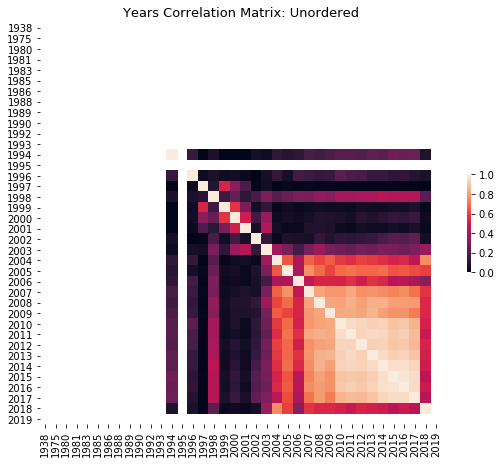

In [21]:
plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(years_correlation,square=True, cbar=True,cbar_kws={"shrink": .2}, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered', size=13)
plt.show()

There seems to be a lot of data missing. 

Let's plot the amount of records in our databse over time to get a better sense on how to approach the problem.

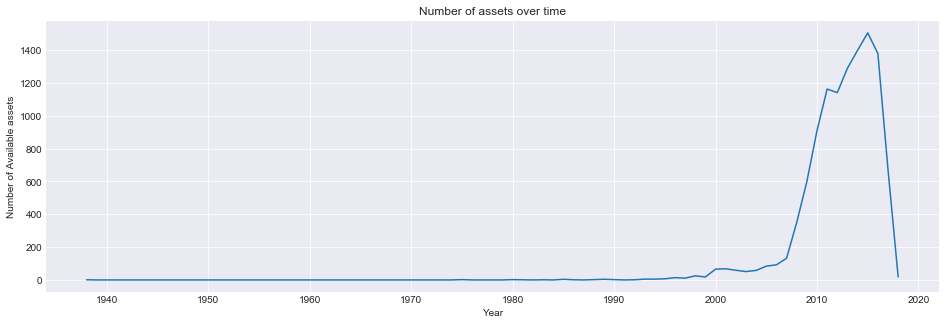

In [22]:
# get all of the data
data = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()
raw = [int(a) for a in data[:-1, 0]]
timeline = range(min(raw), max(raw))
qtties = []

# build a timeline and number of records. 
for year in timeline:
    if year not in raw:
        qtties.append(0)
    else: 
        idx = list(data[:, 0]).index(str(year))
        qtties.append(data[idx, 1])

# re arrange it
amountOfRecords = np.column_stack((timeline, qtties))

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Number of assets over time")
plt.xlabel("Year")
plt.ylabel("Number of Available assets")
plt.plot(timeline, qtties)
plt.show()

### 2.2. Final Year Correlation Matrix <a class="anchor" id="two-two"></a>

To counteract the fact that our dataset is not uniformily distributed across the years, we will only consider the last 22 years. [1997-2018]

In [23]:
number_of_years = 22
numbers_of_years_available = years_correlation.shape[0] - 1
years_in_matrix = years_available[:-1][-number_of_years:]
years_correlation = years_correlation[numbers_of_years_available - number_of_years:numbers_of_years_available, numbers_of_years_available - number_of_years:numbers_of_years_available]

We now rebuild and plot the heatmap of correlations. 

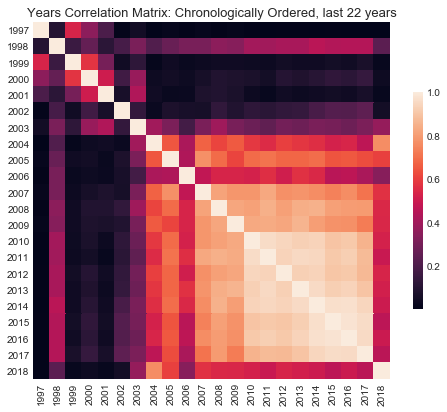

In [24]:
plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=True, cbar_kws={"shrink": .5},square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Chronologically Ordered, last 22 years', size=13)
plt.show()

We save the matrix to a file

In [26]:
np.savetxt("Exports/years_correlation.csv", years_correlation, delimiter=";")    

### 2.3. Year correlation matrix clustering <a class="anchor" id="two-three"></a>

Let us reorder the heatmap according to hierarchical clustering. 

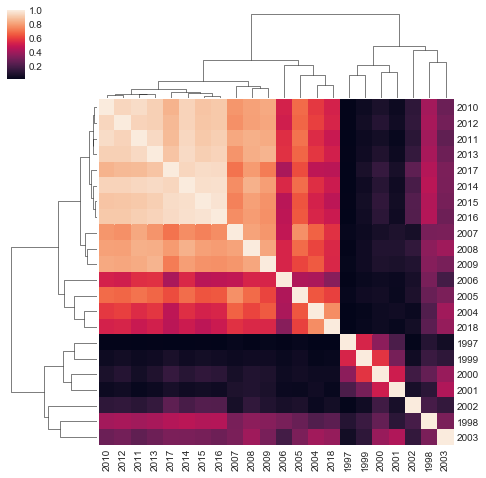

In [27]:
# plot the clustermap
a = sns.clustermap(years_correlation,  figsize=(8, 8), xticklabels = years_in_matrix, yticklabels=years_in_matrix)
plt.show()

Let us see how related is each year in our matrix with the one before it. In this way we might more easily detect discripancies. 

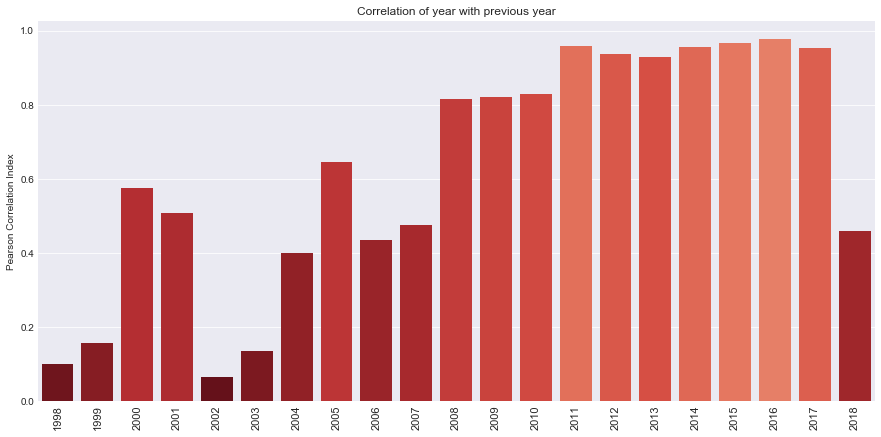

In [28]:
# remove first year
advanced_timeline = years_in_matrix[1::]
corr_with_pre = []

# iterate years and see their correlation 
row = 1
col = 0
for year in advanced_timeline:
    corr_with_pre.append(years_correlation[row, col])
    row = row + 1
    col = col + 1

# plot
plt.subplots(1,1,figsize=(15,7))
pal = sns.color_palette("Reds", len(data))
sns.barplot(np.arange(len(corr_with_pre)), corr_with_pre, palette=np.array(pal[::-1])[np.asarray(corr_with_pre).argsort().argsort()] )
plt.xticks(np.arange(len(corr_with_pre)), advanced_timeline, rotation=90, fontsize=11)
plt.title('Correlation of year with previous year')
plt.ylabel('Pearson Correlation Index')
plt.show()

Some years, such as 2006 or 2007 appear to have very low correlations with the years after. There seems to be an overall tendency of augmenting correlation with the years. 

And we save to file. 

In [29]:
np.savetxt("Exports/corellation with previous.csv", corr_with_pre, delimiter=";")    